# Data Analysis: Tourniquet system
> Authors: German Adolfo Montoya, Carlos Andrés Lozano, Juan Andrés Méndez

In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set the Seaborn theme
sns.set_theme()

excel_path = 'data/SD Feb-May 2019.xlsx'

# Brign forth the Feb-Mar sheet data
df_feb_may = pd.read_excel(excel_path, sheet_name='Feb-Mar')

# Bring forth the Apr-May sheet data
df_abr_may = pd.read_excel(excel_path, sheet_name='Abr-May')

# Concatenate the two dataframes

df = pd.concat([df_feb_may, df_abr_may])

df.index = pd.to_datetime(df['fecha_completa'], format='Y-%m-%d %H:%M:%S')

## Data Pipeline
> Create a data pipeline that drops all the unesesary columns and rows, and creates new columns to better understand the time frame of the data.

In [94]:

def extract_transform_load(df: pd.DataFrame):
    """
    Extracts, transforms, and loads data for entry/exit analysis.

    Args:
        df (pd.DataFrame): Input DataFrame containing access data.

    Returns:
        pd.DataFrame, pd.DataFrame: DataFrames containing entries and exits data.
    """
    # Data Cleaning & Preparation
    df_filtered = (
        df.drop(columns=["PORTERIA", "RESULTADO_EVENTO", "ROL"])
        .query("MODO_ACCESO == 'Peatonal'")
        .drop(columns=["MODO_ACCESO"])
    )
    df_filtered["TIPO_ACCESO"] = df_filtered["TIPO_ACCESO"].str.strip()
    df_filtered["DIA"] = pd.to_numeric(df_filtered["DIA"])
    df_filtered.set_index(pd.to_datetime(df_filtered.index), inplace=True)

    # Drop rows with missing values
    df_filtered.dropna(inplace=True)

    # Drop duplicates
    df_filtered.drop_duplicates(inplace=True)
    # Add day of the week
    df_filtered['day_of_week'] = df_filtered.index.day_name()
    
    # Order day of the week
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    df_filtered['day_of_week'] = pd.Categorical(df_filtered['day_of_week'], categories=day_order, ordered=True)

    # Add week number
    df_filtered['week'] = df_filtered.index.isocalendar().week

    df_filtered['time'] = df_filtered.index.time

    # Separate Entries and Exits
    df_in = df_filtered[df_filtered["TIPO_ACCESO"] == "IN"]
    df_out = df_filtered[df_filtered["TIPO_ACCESO"] == "OUT"]

    return df_in, df_out

## Data Grouping
> Group the data by different date-time intervals to better understand the data.

### Group the data by day of the month
> Group the data by day of the month and create a new column with the day of the month.

In [95]:

def entry_exit_day_of_month(df: pd.DataFrame):
    """
    Extracts, transforms, and loads data for entry/exit analysis.

    Args:
        df (pd.DataFrame): Input DataFrame containing access data.

    Returns:
        alt.Chart: Altair chart object visualizing entries and exits per day.
    """

    # Data Cleaning & Preparation

    [df_in, df_out] = extract_transform_load(df)

    df_in_day = df_in.groupby(["MES", "DIA"]).size().reset_index(name="Entries")
    df_out_day = df_out.groupby(["MES", "DIA"]).size().reset_index(name="Exits")

    # Extract day of the month using the MultiIndex
    df_in_day['DAY'] = df_in_day['DIA']
    df_out_day['DAY'] = df_out_day['DIA']

    # add to the month the prefix Entry or exit such it looks like "Entry - February"
    df_in_day['MES'] = "Entry - " + df_in_day['MES']
    df_out_day['MES'] = "Exit - " + df_out_day['MES']

    # Drop the columns ('MES', 'DIA') from both df_in_day and df_out_day
    df_in_day = df_in_day.drop(columns=["DIA"])
    df_out_day = df_out_day.drop(columns=["DIA"])

    return df_in_day, df_out_day


def plot_entry_exit_per_day_of_month(df_in_day: pd.DataFrame, df_out_day: pd.DataFrame, palette: dict = None):
    """
    Plots the number of entries and exits per day.

    Args:
        df_in_day (pd.DataFrame): DataFrame containing entries per day.
        df_out_day (pd.DataFrame): DataFrame containing exits per day.

    Returns:
        None
    """

    # Plotting
    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot the entries it should plot the entries per day and diferentiate by a hue applied to the month
    sns.lineplot(data=df_in_day, x="DAY", y="Entries", hue="MES", marker="o", palette=palette['Entries'], ax=ax)

    # Plot the exits it should plot the exits per day and diferentiate by a hue applied to the month

    sns.lineplot(data=df_out_day, x="DAY", y="Exits", hue="MES", marker="o", palette=palette['Exits'], ax=ax)

    # Set the title of the plot

    plt.title("Number of Entries and Exits per Day")

    # Set the x-axis label
    plt.xlabel("Day")

    # Set the y-axis label

    plt.ylabel("Number of Entries/Exits")
    plt.show()

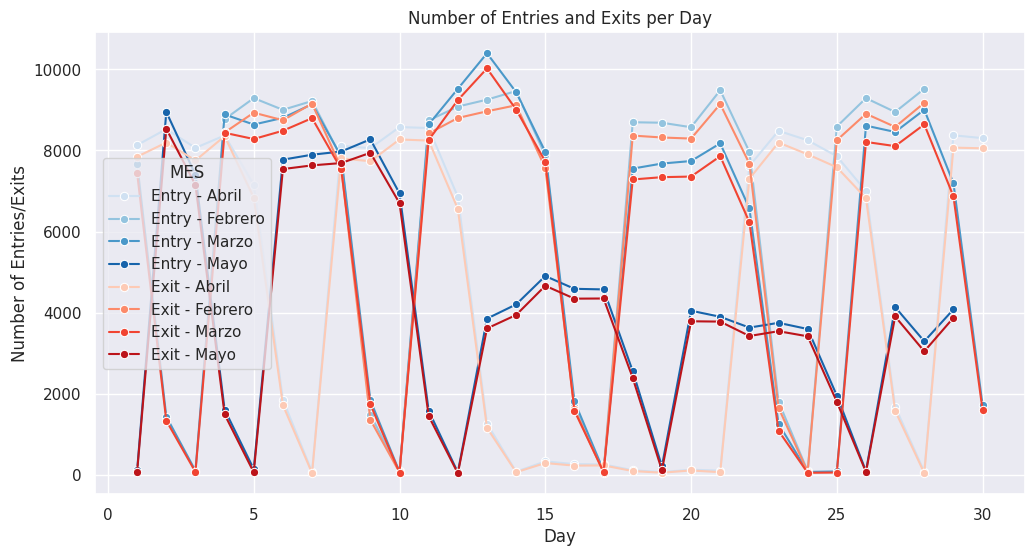

In [96]:
# Execute the function
palette = {"Entries": sns.color_palette("Blues", 4), "Exits": sns.color_palette("Reds", 4)}
[df_in_day, df_out_day] = entry_exit_day_of_month(df)
plot_entry_exit_per_day_of_month(df_in_day, df_out_day, palette)

### Group the data by the day of the week
> Group the data by the day of the week and create a new column with the day of the week.

In [97]:
def entry_exit_day_of_week(df: pd.DataFrame):
    """
    Extracts, transforms, and loads data for entry/exit analysis by day of the week.

    Args:
        df (pd.DataFrame): Input DataFrame containing access data.

    Returns:
        pd.DataFrame, pd.DataFrame: DataFrames containing grouped entries and exits by day of the week.
    """
    # Data Cleaning & Preparation
    df_in, df_out = extract_transform_load(df)
    df_in_week = df_in.groupby(['week', 'day_of_week']).size().reset_index(name='Entries')
    df_out_week = df_out.groupby(['week', 'day_of_week']).size().reset_index(name='Exits')

    return df_in_week, df_out_week

def plot_entry_exit_per_day_of_week(df_in_week: pd.DataFrame, df_out_week: pd.DataFrame, palette: dict = None):
    """
    Plots the number of entries and exits per day of the week.

    Args:
        df_in_week (pd.DataFrame): DataFrame containing entries per day of the week.
        df_out_week (pd.DataFrame): DataFrame containing exits per day of the week.

    Returns:
        None
    """
    # Plotting
    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot the entries per day of the week
    sns.lineplot(data=df_in_week, x='day_of_week', y='Entries', hue='week', marker='o', palette=palette['Entries'], ax=ax)

    # Plot the exits per day of the week
    sns.lineplot(data=df_out_week, x='day_of_week', y='Exits', hue='week', marker='o', palette=palette['Exits'], ax=ax)

    # Set the title of the plot
    plt.title("Number of Entries and Exits per Day of the Week")

    # Set the x-axis label
    plt.xlabel("Day of the Week")

    # Set the y-axis label
    plt.ylabel("Number of Entries/Exits")
    plt.show()

/tmp/ipykernel_18171/1156414004.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_in_week = df_in.groupby(['week', 'day_of_week']).size().reset_index(name='Entries')
/tmp/ipykernel_18171/1156414004.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_out_week = df_out.groupby(['week', 'day_of_week']).size().reset_index(name='Exits')


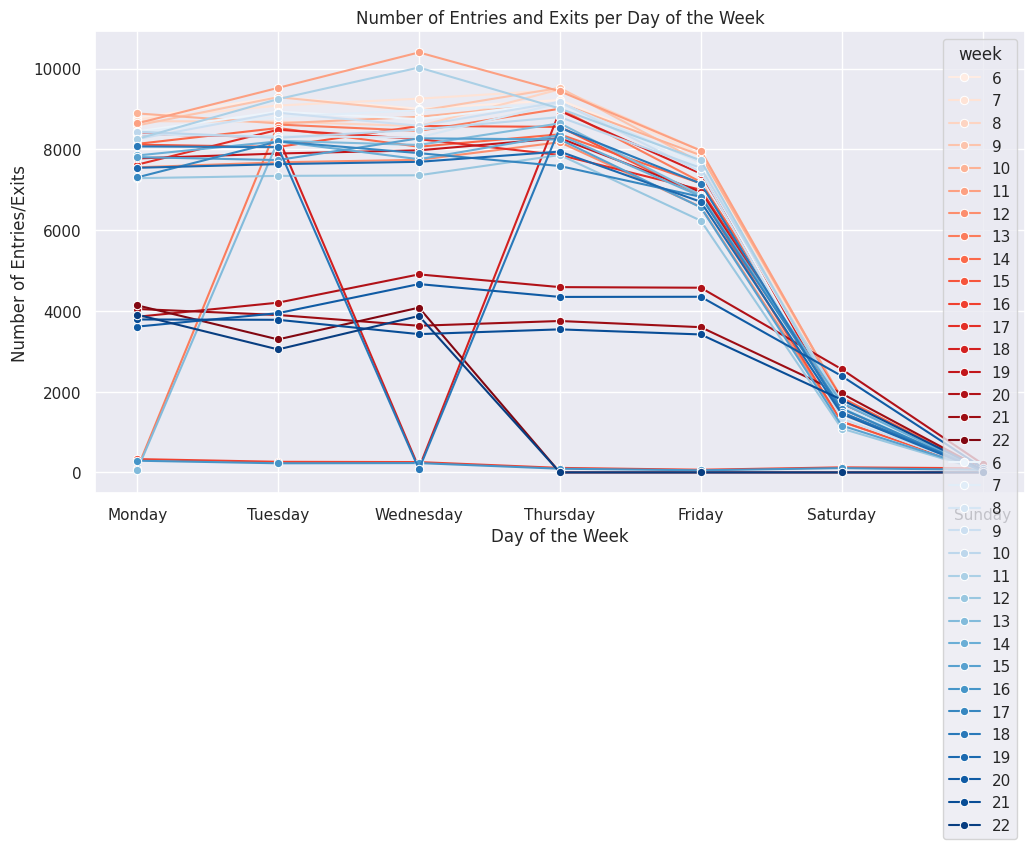

In [98]:
# Day of the week

[df_in_week, df_out_week] = entry_exit_day_of_week(df)

palette = {"Entries": sns.color_palette("Reds", 17), "Exits": sns.color_palette("Blues", 17)}
plot_entry_exit_per_day_of_week(df_in_week, df_out_week, palette)

### Group the entries and exits by hour every 5 minutes
> Group the entries and exits by hour every 5 minutes and create a new column with the time frame.

In [99]:
def entry_exit_by_5min_interval(df: pd.DataFrame):
    """
    Groups entries and exits by 5-minute intervals for each day of the week.

    Args:
        df (pd.DataFrame): Input DataFrame containing access data.

    Returns:
        dict: Dictionary containing DataFrames of grouped entries and exits for each day of the week.
    """
    df_in, df_out = extract_transform_load(df)

    # Initialize dictionaries to hold DataFrames
    df_in_5min = {}
    df_out_5min = {}

    # Group by 5-minute intervals for each day of the week
    for day in df_in['day_of_week'].cat.categories:
        df_in_day = df_in[df_in['day_of_week'] == day].set_index('fecha_completa').resample('5T').size().reset_index(name='Entries')
        df_out_day = df_out[df_out['day_of_week'] == day].set_index('fecha_completa').resample('5T').size().reset_index(name='Exits')

        # Only keep non-zero entries
        df_in_day = df_in_day[df_in_day['Entries'] > 0]
        df_out_day = df_out_day[df_out_day['Exits'] > 0]

        df_in_day['time'] = df_in_day['fecha_completa'].dt.time.astype(str)
        df_out_day['time'] = df_out_day['fecha_completa'].dt.time.astype(str)

        df_in_day.set_index('time', inplace=True)
        df_out_day.set_index('time', inplace=True)

        df_in_5min[day] = df_in_day
        df_out_5min[day] = df_out_day

    return df_in_5min, df_out_5min


def plot_entry_exit_per_5min_interval(df_in_5min: dict, df_out_5min: dict):
    """
    Plots the number of entries and exits per 5-minute interval for each day of the week.

    Args:
        df_in_5min (dict): Dictionary containing DataFrames of entries per 5-minute interval for each day of the week.
        df_out_5min (dict): Dictionary containing DataFrames of exits per 5-minute interval for each day of the week.

    Returns:
        None
    """
    # Plotting for each day of the week
    for day in df_in_5min.keys():
        fig, ax = plt.subplots(figsize=(12, 6))
        
        # Plot the entries per 5-minute interval
        sns.lineplot(data=df_in_5min[day], x=df_in_5min[day].index, y='Entries', marker='o', label='Entries', ax=ax, color='red')

        # Plot the exits per 5-minute interval
        sns.lineplot(data=df_out_5min[day], x=df_out_5min[day].index, y='Exits', marker='o', label='Exits', ax=ax, color='blue')

        # Set the title of the plot
        plt.title(f"Number of Entries and Exits per 5-Minute Interval on {day}")

        # Set the x-axis label
        plt.xlabel("Time")

        # Set the y-axis label
        plt.ylabel("Number of Entries/Exits")

        plt.legend()
        plt.show()

/tmp/ipykernel_18171/933445853.py:19: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_in_day = df_in[df_in['day_of_week'] == day].set_index('fecha_completa').resample('5T').size().reset_index(name='Entries')
/tmp/ipykernel_18171/933445853.py:20: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_out_day = df_out[df_out['day_of_week'] == day].set_index('fecha_completa').resample('5T').size().reset_index(name='Exits')
/tmp/ipykernel_18171/933445853.py:19: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_in_day = df_in[df_in['day_of_week'] == day].set_index('fecha_completa').resample('5T').size().reset_index(name='Entries')
/tmp/ipykernel_18171/933445853.py:20: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_out_day = df_out[df_out['day_of_week'] == day].set_index('fec

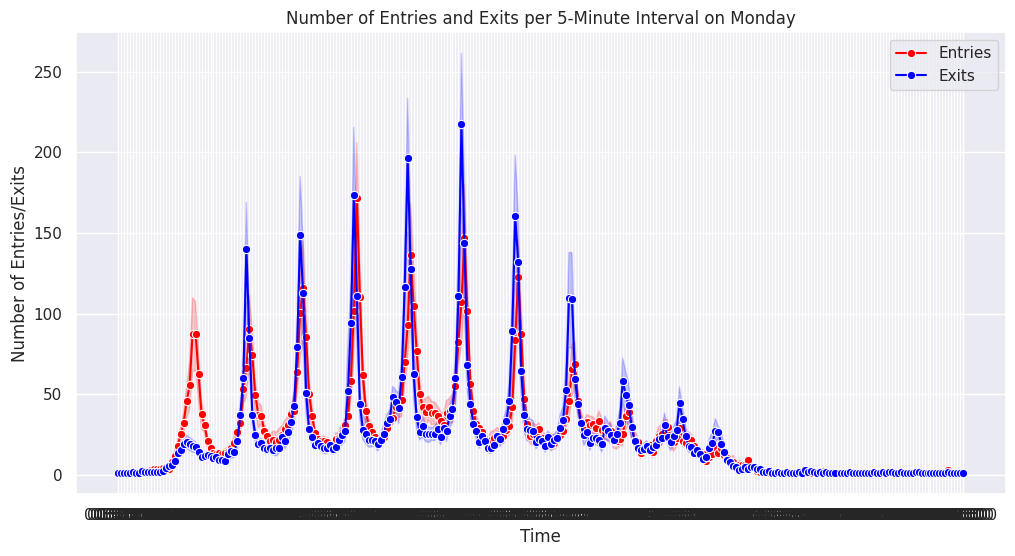

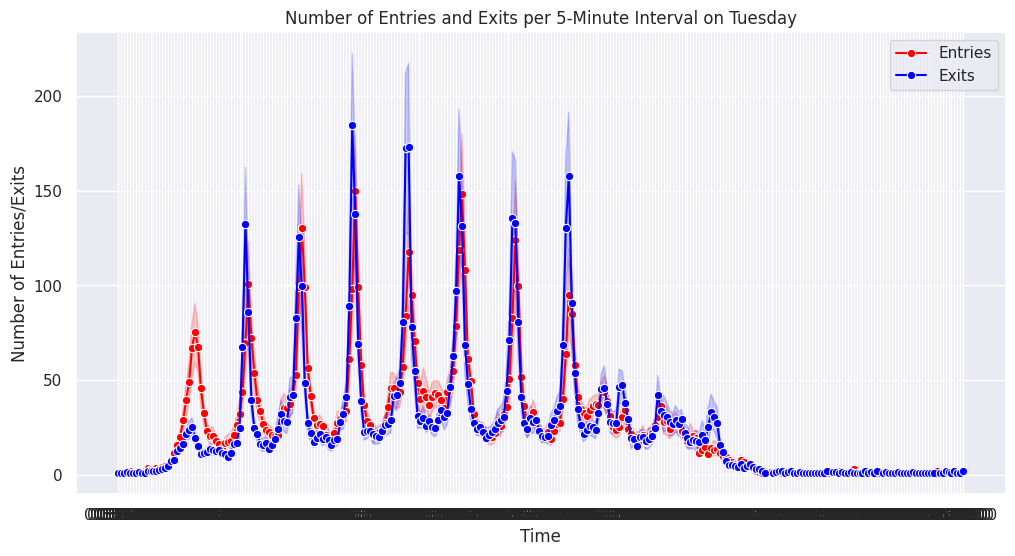

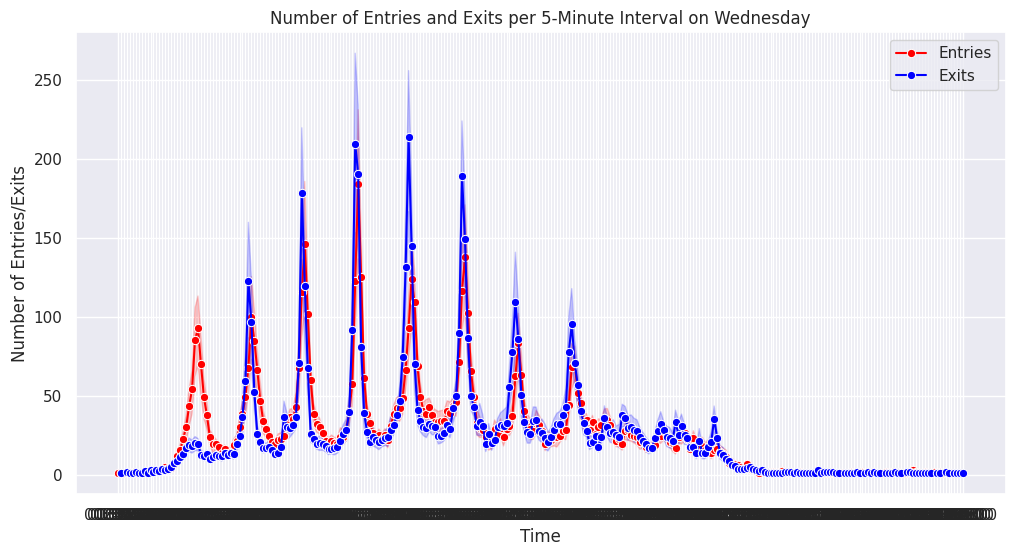

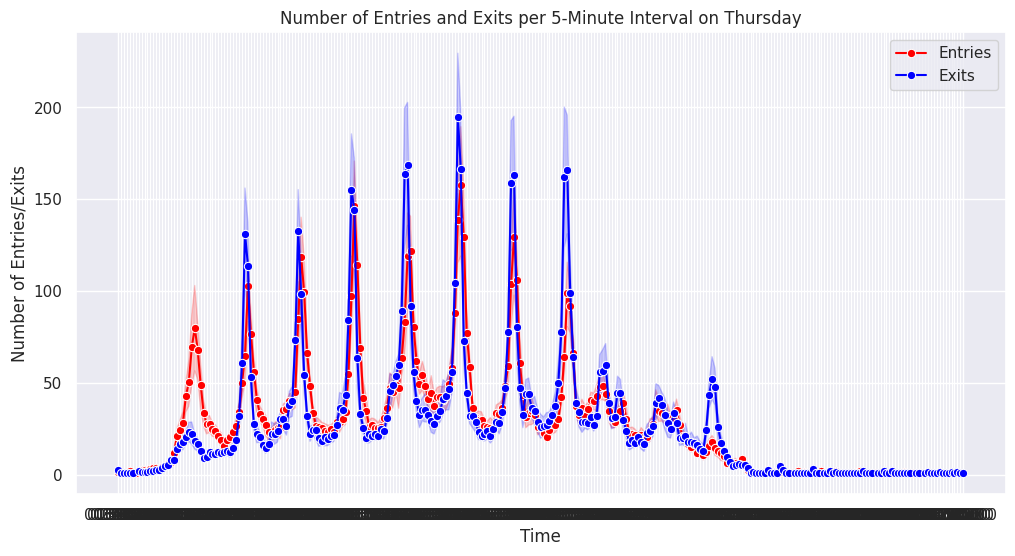

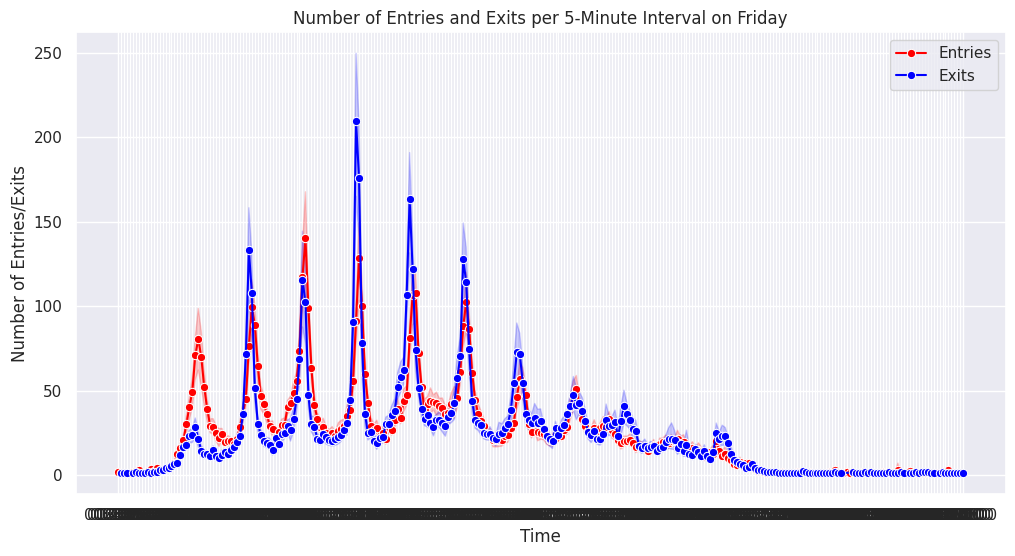

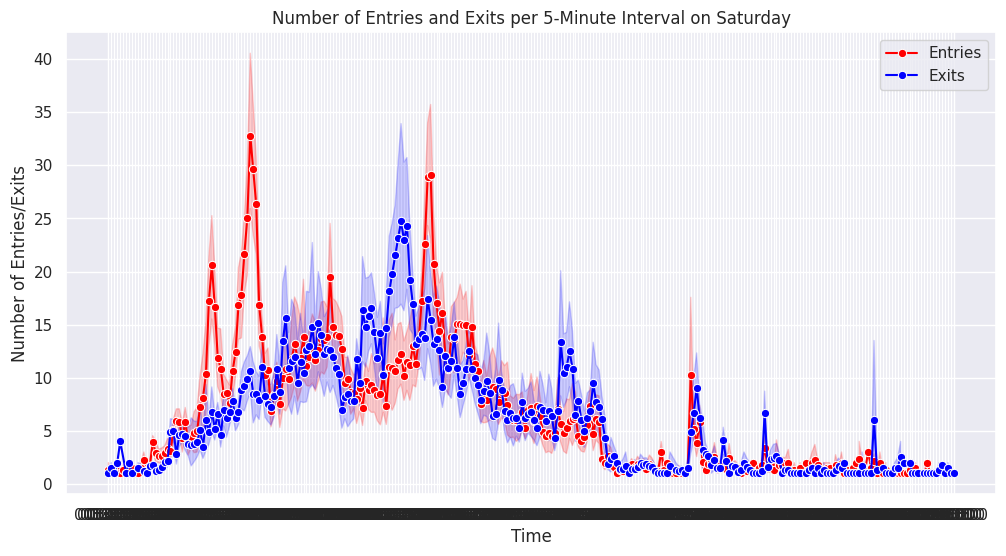

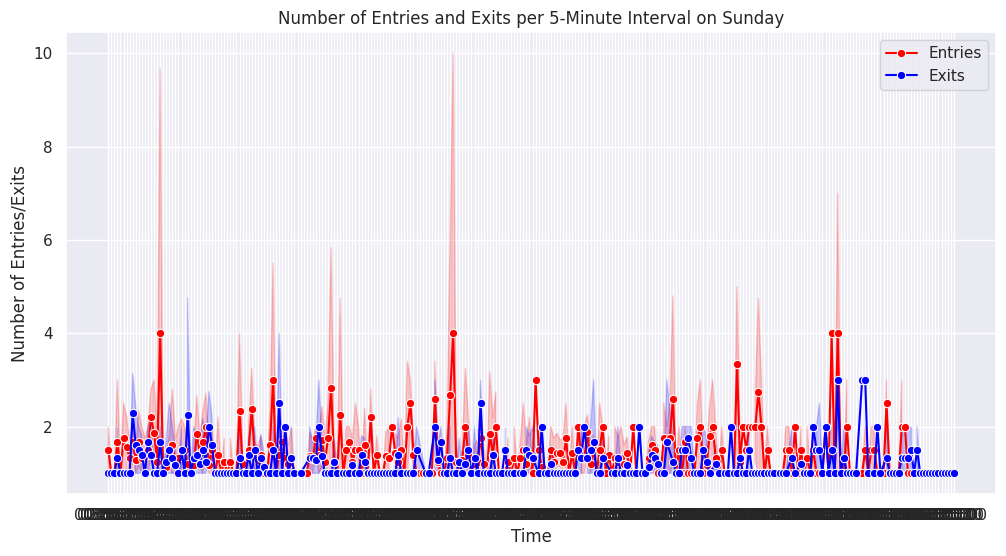

In [100]:
df_in_5min, df_out_5min = entry_exit_by_5min_interval(df)
plot_entry_exit_per_5min_interval(df_in_5min, df_out_5min)

## Analysis of temporal and tendencial data
> Analyze the data to find trends and patterns in the data.

The simplest way to extract the behaviour of the data is to group it by day of the week and by hour of the day. This will allow us to see the behaviour of the data in a more general way.

Now that we have the data grouped this way we can get every single instance of entries and exits every 5 minutes and for every five minuts we are going to calculate the average of entries and exits and then add a variabilization of the data based on the lowest and highest values of entries and exits in that time frame.

In [105]:
def get_randomized_turnstile_usage(df_in_5min: dict, df_out_5min: dict, day_of_week: str, time: str):
    """
    Returns a random turnstile usage for a given day of the week and time.

    Args:
        df_in_5min (dict): Dictionary containing DataFrames of entries per 5-minute interval for each day of the week.
        df_out_5min (dict): Dictionary containing DataFrames of exits per 5-minute interval for each day of the week.
        day_of_week (str): Day of the week.
        time (str): Time of the day.

    Returns:
        pd.DataFrame: DataFrame containing a random turnstile usage for the given day of the week and time.
    """

    # Randomly select a turnstile usage for the given day of the week and time
    df_in = df_in_5min[day_of_week]
    df_out = df_out_5min[day_of_week]

    # Randomly select a turnstile usage for the given day of the week and time
    avg_entries = df_in.loc[time, 'Entries'].mean()
    avg_exits = df_out.loc[time, 'Exits'].mean()

    # Generate random entries and exits based on the average values and a normal distribution
    np.random.seed(0)
    entries = np.random.normal(avg_entries, 10)
    exits = np.random.normal(avg_exits, 10)

    return entries, exits

In [108]:
df_in_5min, df_out_5min = entry_exit_by_5min_interval(df)

day_of_week = 'Monday'
time = '08:00:00'

df_in, df_out = get_randomized_turnstile_usage(df_in_5min, df_out_5min, day_of_week, time)

print(f"Random Turnstile Usage for {day_of_week} at {time}")
print("Entries:")
print(df_in)
print("\nExits:")
print(df_out)

Random Turnstile Usage for Monday at 08:00:00
Entries:
              fecha_completa  Entries
time                                 
08:00:00 2019-05-27 08:00:00       23

Exits:
              fecha_completa  Exits
time                               
08:00:00 2019-05-20 08:00:00     20


/tmp/ipykernel_18171/933445853.py:19: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_in_day = df_in[df_in['day_of_week'] == day].set_index('fecha_completa').resample('5T').size().reset_index(name='Entries')
/tmp/ipykernel_18171/933445853.py:20: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_out_day = df_out[df_out['day_of_week'] == day].set_index('fecha_completa').resample('5T').size().reset_index(name='Exits')
/tmp/ipykernel_18171/933445853.py:19: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_in_day = df_in[df_in['day_of_week'] == day].set_index('fecha_completa').resample('5T').size().reset_index(name='Entries')
/tmp/ipykernel_18171/933445853.py:20: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_out_day = df_out[df_out['day_of_week'] == day].set_index('fec

In [103]:
df_in_5min['Monday']

,fecha_completa,Entries
time,,
00:50:00,2019-02-04 00:50:00,1
00:55:00,2019-02-04 00:55:00,1
01:15:00,2019-02-04 01:15:00,1
03:35:00,2019-02-04 03:35:00,2
03:40:00,2019-02-04 03:40:00,1
...,...,...
22:20:00,2019-05-27 22:20:00,1
22:35:00,2019-05-27 22:35:00,1
22:45:00,2019-05-27 22:45:00,2
